<div>
<img src="https://discuss.pytorch.org/uploads/default/original/2X/3/35226d9fbc661ced1c5d17e374638389178c3176.png" width="400" style="margin: 50px auto; display: block; position: relative; left: -30px;" />
</div>

<!--NAVIGATION-->
# < [Modules](4-Modules.ipynb) | Convolutional Neural Networks | [Transfer Learning](6-Transfer-Learning.ipynb) >



### Convolutional Neural Networks

In this notebook, we first give a short introduction to convolutions, which are a prerequisite to understand how CNNs work.  
Then, we will write code to create a CNN, load the data and train our model.  

<p>
<img src="https://github.com/theevann/amld-pytorch-workshop/blob/master/figures/sprinkle.jpg?raw=1" width="250" style="margin-left: auto;margin-right: auto;display: block;" />
</p>

### Table of Contents

#### 1. [What is a convolution ?](#What-is-a-convolution-?)  
#### 2. [Building a CNN](#Building-a-CNN)
#### 3. [Training our CNN](#Training-our-CNN)

___

In [0]:
! pip -q install colorama
! wget -q https://github.com/theevann/amld-pytorch-workshop/raw/master/figures/image-city.jpg

In [0]:
import sys
import colorama
from collections import OrderedDict
from matplotlib import pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(precision=3)

---

# What is a convolution ?

_Note: Below are **intuitive and practical** explanations that do not intent to be mathematically rigorous. This is intentional to make the understanding easier._

## 1D Convolution

A convolution is an operation between two signals.  
In computer vision, one signal is usually the **input** (audio signal, image, ...), while the other signal is called **filter** or **kernel**.

To get the convolution output of an input vector and a kernel:
- **Slide the kernel** at each different possible positions in the input
- For each position, perform the **element-wise product** between the kernel and the corresponding part of the input
- **Sum** the result of the element-wise product

![convolution 1d](https://github.com/theevann/amld-pytorch-workshop/blob/master/figures/conv-1d.gif?raw=1)

We can perform this operation in PyTorch using the `conv_1d` function.

In [3]:
input = torch.Tensor([1,4,-1,0,2,-2,1,3,3,1]).view(1,1,-1)  # Size: (Batch size, Num Channels, Input size)
kernel = torch.Tensor([1,2,0,-1]).view(1,1,-1)  # Size: (Num output channels, Num input channels, Kernel size)

torch.nn.functional.conv1d(input, kernel)

tensor([[[ 9.,  0.,  1.,  3., -5., -3.,  6.]]])

## 2D Convolution

The extension to 2D is straightforward: the operation is similar, but now input and kernel are both 2-dimensional.

![convolution 2d](https://github.com/theevann/amld-pytorch-workshop/blob/master/figures/conv-2ds.gif?raw=1)

We can perform this operation in PyTorch using the `conv_2d` function.

In [4]:
# Input Size: (Batch size, Num channels, Input height, Input width)
input = torch.Tensor([[3,3,2,1,0], [0,0,1,3,1], [3,1,2,2,3], [2,0,0,2,2], [2,0,0,0,1]]).view(1,1,5,5)

# Kernel Size: (Num output channels, Num input channels, Kernel height, Kernel width)
kernel = torch.Tensor([[0,1,2],[2,2,0],[0,1,2]]).view(1,1,3,3)

torch.nn.functional.conv2d(input, kernel)

tensor([[[[12., 12., 17.],
          [10., 17., 19.],
          [ 9.,  6., 14.]]]])

## Multiple channels

You can use have multiple channels in input. A color image usually have 3 input channels : RGB.  
Therefore, the kernel will also have channels, one for each input channel.

<img src="https://github.com/theevann/amld-pytorch-workshop/blob/master/figures/conv-2d-in-channels.gif?raw=1" alt="drawing" width="700"/>

You can use multiple different kernels. The number of output channels corresponds to the number of kernel you use.

<img src="https://github.com/theevann/amld-pytorch-workshop/blob/master/figures/conv-2d-out-channels.gif?raw=1" alt="drawing" width="400"/>

## Trying on a real image

(600, 348)


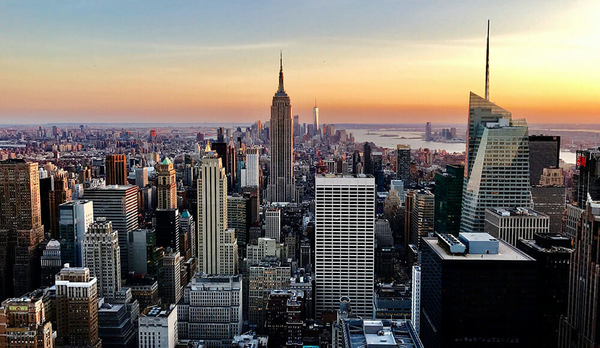

In [5]:
from PIL import Image

image = Image.open("image-city.jpg")
print(image.size)
image

#### **Your Turn !**

**Fill in the code cell below to perform the convolution of the above image with a kernel.**  
We will use a boundary detector filter as kernel:

$$\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 
\end{bmatrix}
$$

Pay attention to the dimensions of the input and the kernel:
- Input Size: **Batch size** x **Num channels** x **Input height** x **Input width**
- Kernel Size: **Num output channels** x **Num input channels** x **Kernel height** x **Kernel width**

Note:
- There are 3 input channels (since we have an rgb image)
- In output, we want only one channel (ie. we define only one kernel)
- Here, batch size will be 1.

In [0]:
# %load -r 1-8 solutions/solution_5.py
from torchvision.transforms.functional import to_tensor, to_pil_image

image_tensor = to_tensor(image)
input = image_tensor.unsqueeze(0)
kernel = torch.Tensor([-1,0,1]).expand(1,3,3,3)

out =  torch.nn.functional.conv2d(input, kernel)

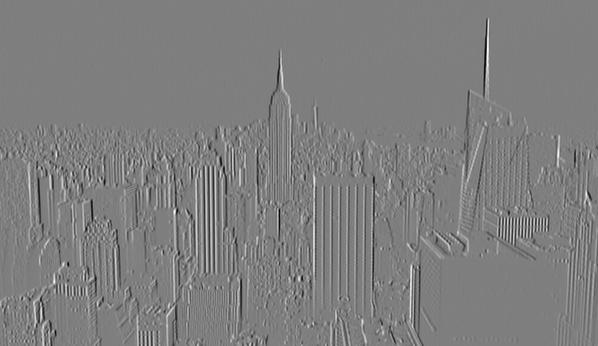

In [7]:
norm_out = (out - out.min()) / (out.max() - out.min())  # Map output to [0,1] for visualisation purposes
to_pil_image(norm_out.squeeze())

## Convolutions in `nn.Module`

When using a convolution layer inside an `nn.Module`, we rather use the `nn.Conv2d` module.  
The kernels of the convolution are directly instantiated by `nn.Conv2d`.

In [8]:
conv_1 = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3,3))

print("Convolution", conv_1)
print("Kernel size: ", conv_1.weight.shape) # First two dimensions are: Num output channels and Num input channels

Convolution Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1))
Kernel size:  torch.Size([2, 3, 3, 3])


In [9]:
# Fake 5x5 input with 3 channels
input = torch.randn(1, 3, 5, 5)  # batch_size, num_channels, height, width

out = conv_1(input)
print(out)

tensor([[[[ 0.633, -0.174, -0.303],
          [-1.098,  0.044,  0.069],
          [ 0.098,  1.179, -0.050]],

         [[-0.785, -1.141, -0.021],
          [ 0.244, -0.325,  0.391],
          [-0.381,  0.173,  1.089]]]], grad_fn=<MkldnnConvolutionBackward>)


_Animations credits: Francois Fleuret, Vincent Dumoulin_

---

# Building a CNN 

We will use the MNIST classification dataset again as our learning task. However, this time we will try to solve it using Convolutional Neural Networks. Let's build the LeNet-5 CNN with PyTorch !

## Defining the LeNet-5 architecture

![](https://pytorch.org/tutorials/_images/mnist.png)

*Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.*

_Note: The *Gaussian connections* in the last layer were used to estimate the lack of fit. In our implementation, we use a cross-entropy loss function as it's common nowadays. Similarly, ReLU are used instead of tanh activation._

**Architecture Details**

+ Convolutional part:


| Layer       | Name | Input channels | Output channels | Kernel | stride |
| ----------- | :--: | :------------: | :-------------: | :----: | :----: |
| Convolution |  C1  |       1        |        6        |  5x5   |   1    |
| ReLU        |      |       6        |        6        |        |        |
| MaxPooling  |  S2  |       6        |        6        |  2x2   |   2    |
| Convolution |  C3  |       6        |       16        |  5x5   |   1    |
| ReLU        |      |       16       |       16        |        |        |
| MaxPooling  |  S4  |       16       |       16        |  2x2   |   2    |
| Convolution |  C5  |       6        |       120       |  5x5   |   1    |
| ReLU        |      |      120       |       120       |        |        |


+ Fully Connected part:

| Layer      | Name | Input size | Output size |
| ---------- | :--: | :--------: | :---------: |
| Linear     |  F5  |    120     |     84      |
| ReLU       |      |            |             |
| Linear     |  F6  |     84     |     10      |
| LogSoftmax |      |            |             |


#### **Your turn !**

Write a Pytorch module for the LeNet-5 model.  
You may need to use : `nn.Sequential`, `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, `nn.Linear`, `nn.LogSoftmax`, `nn.Flatten`

In [0]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv_net = nn.Sequential(OrderedDict([
            ('C1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('Relu1', nn.ReLU()),
            
            ('S2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('C3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('Relu3', nn.ReLU()),
            
            ('S4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('C5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('Relu5', nn.ReLU()),
        ]))
        
        self.fully_connected = nn.Sequential(OrderedDict([
            ('F6', nn.Linear(120, 84)),
            ('Relu6', nn.ReLU()),
            ('F7', nn.Linear(84, 10)),
            ('LogSoftmax', nn.LogSoftmax(dim=-1))
        ]))
        
        
    def forward(self, imgs):
        output = self.conv_net(imgs)
        output = output.view(imgs.shape[0], -1)  # imgs.shape[0] is the batch_size
        output = self.fully_connected(output)
        return output        

An extensive list of all available layer types can be found on https://pytorch.org/docs/stable/nn.html.

### Print a network summary

In [13]:
conv_net = LeNet5()
print(conv_net)

LeNet5(
  (conv_net): Sequential(
    (C1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (Relu1): ReLU()
    (S2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (Relu3): ReLU()
    (S4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (Relu5): ReLU()
  )
  (fully_connected): Sequential(
    (F6): Linear(in_features=120, out_features=84, bias=True)
    (Relu6): ReLU()
    (F7): Linear(in_features=84, out_features=10, bias=True)
    (LogSoftmax): LogSoftmax()
  )
)


### Retrieve trainable parameters

In [14]:
named_params = list(conv_net.named_parameters())
print("len(params): %s\n" % len(named_params))
for name, param in named_params:
    print("%s:\t%s" % (name, param.shape))

len(params): 10

conv_net.C1.weight:	torch.Size([6, 1, 5, 5])
conv_net.C1.bias:	torch.Size([6])
conv_net.C3.weight:	torch.Size([16, 6, 5, 5])
conv_net.C3.bias:	torch.Size([16])
conv_net.C5.weight:	torch.Size([120, 16, 5, 5])
conv_net.C5.bias:	torch.Size([120])
fully_connected.F6.weight:	torch.Size([84, 120])
fully_connected.F6.bias:	torch.Size([84])
fully_connected.F7.weight:	torch.Size([10, 84])
fully_connected.F7.bias:	torch.Size([10])


### Feed network with a random input

In [15]:
input = torch.randn(1, 1, 32, 32)  # batch_size, num_channels, height, width
out = conv_net(input)
print("Log-Probabilities: \n%s\n" % out)
print("Probabilities: \n%s\n" % torch.exp(out))
print("out.shape: \n%s" % (out.shape,))

Log-Probabilities: 
tensor([[-2.283, -2.247, -2.183, -2.315, -2.261, -2.379, -2.430, -2.405, -2.323,
         -2.229]], grad_fn=<LogSoftmaxBackward>)

Probabilities: 
tensor([[0.102, 0.106, 0.113, 0.099, 0.104, 0.093, 0.088, 0.090, 0.098, 0.108]],
       grad_fn=<ExpBackward>)

out.shape: 
torch.Size([1, 10])


---

# Training our CNN

### Train function 

Similarly to the previous notebook, we define a train function `train_cnn`.

In [0]:
def train_cnn(model, train_loader, test_loader, device, num_epochs=3, lr=0.1):

    # define an optimizer and a loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print("=" * 40, "Starting epoch %d" % (epoch + 1), "=" * 40)
        
        model.train()  # Not necessary in our example, but still good practice.
                       # Only models with nn.Dropout and nn.BatchNorm modules require it
                
        # dataloader returns batches of images for 'data' and a tensor with their respective labels in 'labels'
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 40 == 0:
                print("Batch %d/%d, Loss=%.4f" % (batch_idx, len(train_loader), loss.item()))
        
        # Compute the train and test accuracy at the end of each epoch
        train_acc = accuracy(model, train_loader, device)
        test_acc = accuracy(model, test_loader, device)
        
        print(colorama.Fore.GREEN, "\nAccuracy on training: %.2f%%" % (100*train_acc))
        print("Accuracy on test: %.2f%%" % (100*test_acc), colorama.Fore.RESET)

### Test function
We also define an `accuracy` function which can evaluate our model's accuracy on train/test data

In [0]:
def accuracy(model, dataloader, device):
    """ Computes the model's accuracy on the data provided by 'dataloader'
    """
    model.eval()
    
    num_correct = 0
    num_samples = 0
    with torch.no_grad():  # deactivates autograd, reduces memory usage and speeds up computations
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            predictions = model(data).max(1)[1]  # indices of the maxima along the second dimension
            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
        
    return num_correct / num_samples

### Loading the train and test data with *`dataloaders`*

In [19]:
from torchvision import datasets, transforms

transformations = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_data = datasets.MNIST('./data', 
                            train = True, 
                            download = True,
                            transform = transformations)

test_data = datasets.MNIST('./data', 
                            train = False, 
                            download = True,
                            transform = transformations)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 9774035.60it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142809.15it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2592783.84it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 52355.86it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


#### Let's visualize some of the training samples

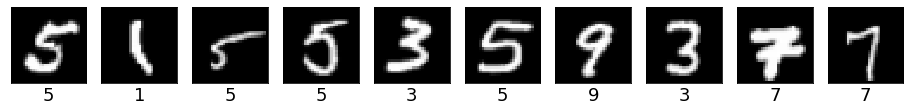

In [20]:
plt.figure(figsize=(16,9))
data, target = next(iter(train_loader))
for i in range(10):
    img = data.squeeze(1)[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap="gray", interpolation="none")
    plt.xlabel(target[i].item(), fontsize=18)
    plt.xticks([])
    plt.yticks([])

### Start the training!

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conv_net = conv_net.to(device)

train_cnn(conv_net, train_loader, test_loader, device, lr=2e-3)

======================================== Starting epoch 1 ========================================
Batch 0/235, Loss=2.3008
Batch 40/235, Loss=0.4317
Batch 80/235, Loss=0.2836
Batch 120/235, Loss=0.2103
Batch 160/235, Loss=0.1586
Batch 200/235, Loss=0.0845
 
Accuracy on training: 96.52%
Accuracy on test: 96.78% 
======================================== Starting epoch 2 ========================================
Batch 0/235, Loss=0.1248
Batch 40/235, Loss=0.1300
Batch 80/235, Loss=0.0672
Batch 120/235, Loss=0.0458
Batch 160/235, Loss=0.0315
Batch 200/235, Loss=0.0583
 
Accuracy on training: 98.04%
Accuracy on test: 98.11% 
======================================== Starting epoch 3 ========================================
Batch 0/235, Loss=0.0575
Batch 40/235, Loss=0.1051
Batch 80/235, Loss=0.0525
Batch 120/235, Loss=0.0317
Batch 160/235, Loss=0.1154
Batch 200/235, Loss=0.1073
 
Accuracy on training: 98.46%
Accuracy on test: 98.31% 


### Let's look at some of the model's predictions

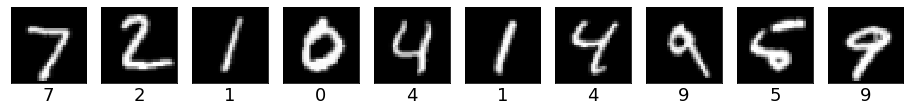

In [22]:
def visualize_predictions(model, dataloader, device):
    data, labels = next(iter(dataloader))
    data, labels = data[:10].to(device), labels[:10]
    predictions = model(data).max(1)[1]
    
    predictions, data = predictions.cpu(), data.cpu()
    
    plt.figure(figsize=(16,9))
    for i in range(10):
        img = data.squeeze(1)[i]
        plt.subplot(1, 10, i+1)
        plt.imshow(img, cmap="gray", interpolation="none")
        plt.xlabel(predictions[i].item(), fontsize=18)
        plt.xticks([])
        plt.yticks([])    
    
visualize_predictions(conv_net, test_loader, device)

___

<!--NAVIGATION-->
# < [Modules](4-Modules.ipynb) | Convolutional Neural Networks | [Transfer Learning](6-Transfer-Learning.ipynb) >